# Kohonen self organizing map 

In [1]:
using Random, PyPlot, ProgressMeter

In [2]:
product(sets...) = hcat([collect(x) for x in Iterators.product(sets...)]...)' # Array of Cartesian product of sets 
pol2cart(θ, r) = [r*cos(θ), r*sin(θ)];

In [3]:
# generate stimulus
Random.seed!(1234);
Nx, Ny, NOD, NOR = 10, 10, 2, 12
Din = 5  # dims of inputs 
l, r = 0.14, 0.2

rx, ry = range(0, 1, length=Nx), range(0, 1, length=Ny)
rOD = range(-l, l, length=NOD)
rORθ = range(-π/2, π/2, length=NOR+1)[1:end-1]

# stimuli
v = product(rx, ry, rOD, rORθ, r)
rORxy = hcat(pol2cart.(2v[:, 4], v[:, 5])...)
v[:, 4], v[:, 5] = rORxy[1, :], rORxy[2, :];
v += (rand(size(v)...) .- 1) * 1e-5;

In [4]:
# initial neurons
map_width = 64
M = map_width^2
w = product(range(0, 1, length=map_width), range(0, 1, length=map_width))
w += (rand(size(w)...) .- 1) * 0.05;
w = [w 2l*(rand(M) .- 0.5) hcat(pol2cart.(4π*(rand(M) .- 0.5), r*rand(M))...)']
w = reshape(w, (map_width, map_width, Din));

In [5]:
function plot_visual_maps(v, w)
    figure(figsize=(8, 8))
    subplot(2,2,1)
    title("Retinotopic map")
    scatter(v[:, 1], v[:, 2], s=5); scatter(w[:, :, 1], w[:, :, 2], s=5); 
    plot(w[:, :, 1], w[:, :, 2], "k", linewidth=1); plot(w[:, :, 1]', w[:, :, 2]', "k", linewidth=1)
    
    subplot(2,2,2)
    title("Orientation (OR) angle map")
    ORmap = atan.(w[:, :, 5], w[:, :, 4]); # get angle of polar 
    imshow(ORmap, cmap="hsv", origin="lower")

    subplot(2,2,3)
    title("Ocular dominance (OD) map")
    imshow(w[:, :, 3], cmap="gray", origin="lower") 
    
    subplot(2,2,4)
    title("Contours of OD and OR")
    sizex, sizey = map_width, map_width
    x, y = 0:sizex-1, 0:sizey-1
    X, Y = ones(sizey) * x', y * ones(sizex)';
    contour(X, Y, ORmap, cmap="hsv")
    contour(X, Y, w[:, :, 3], colors="k", levels=1)
    tight_layout()
end;

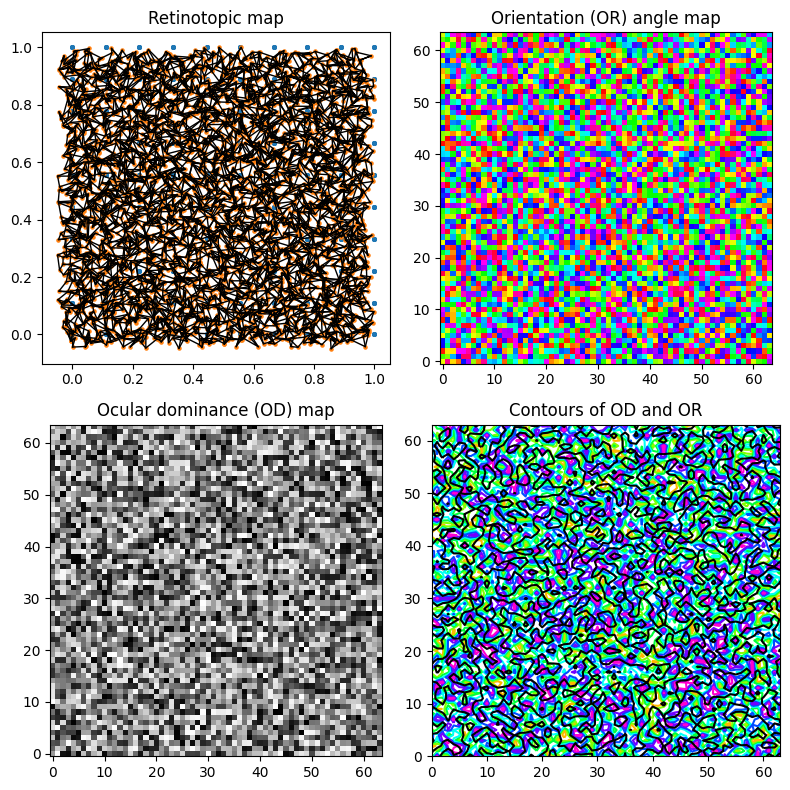

In [6]:
plot_visual_maps(v, w)

In [7]:
# Gaussian mask for inputs
function GaussianMask(sizex=9, sizey=9; σ=5)
    x, y = 0:sizex-1, 0:sizey-1
    X, Y = ones(sizey) * x', y * ones(sizex)' 
    
    x0, y0 = (sizex-1) / 2, (sizey-1) / 2
    mask = exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / (2.0(σ^2)))
    return mask ./ sum(mask)
end

GaussianMask (generic function with 3 methods)

In [8]:
function SOM!(v, w; η0=1.0, σ0=5, T=50)
    #  η0: update rate, σ0 : width, T : training steps
    map_width = size(w)[1]
    N = size(v)[1]
    w_history = []
    @showprogress for t in 1:T
        η = η0 * (1 - t/T); # update rate
        σ = round(Int, (σ0 - 1) * (1 - t/T) + 1); # decay from large to small
        mask = GaussianMask(2σ+1, 2σ+1, σ=σ);
        
        # loop for the N inputs
        for i in 1:N
            dist = sum([(v[i, j] .- w[:, :, j]).^2 for j in 1:Din]) # distance between input and neurons
            win_idx = argmin(dist) # winner index
            idx = [max(1,win_idx[j] - σ):min(map_width, win_idx[j] + σ) for j in 1:2] # neighbor indices
            # update the winner & neighbor neuron    
            for j in 1:Din
                w[idx..., j] += η * mask[1:length(idx[1]), 1:length(idx[2])] .* (v[i, j] .- w[idx..., j])
            end
        end
        append!(w_history, [w])
    end
    return w_history
end

SOM! (generic function with 1 method)

In [9]:
SOM!(v, w);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:169m


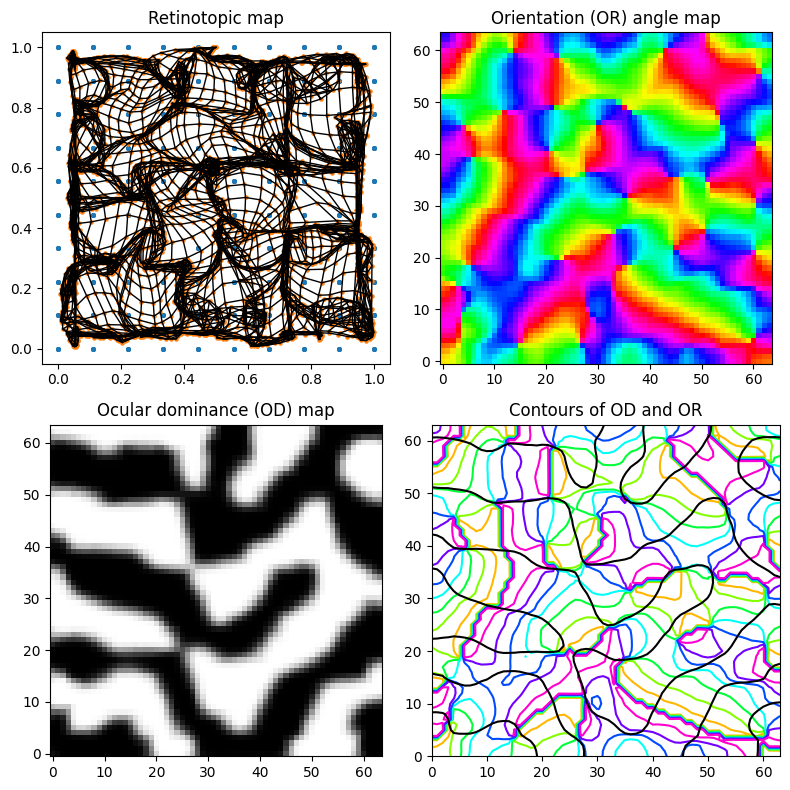

In [10]:
plot_visual_maps(v, w)